# Transfer Learning Using BERT


## What is transfer learning?

Transfer learning is a machine learning technique where a model trained on one task is adapted or fine-tuned to work on a different but related task. It's a way to leverage the knowledge acquired from one problem to solve another, potentially saving a lot of time and resources in training a new model from scratch.

Transfer learning, in particular, often involves the utilization of existing pre-trained large language models. In traditional statistical approaches to Natural Language Processing (NLP), like text classification, we typically create custom features and then use machine learning models such as logistic regression or support vector machines to learn how to classify text based on those features.

In contrast, deep learning, which is the basis for most Large Language Models (LLMs), not only learns how to classify but also discovers underlying, hidden features through a deep neural network.

As a result, a task-specific classifier can gain significant advantages from a pre-trained language model by directly using its output as input for downstream tasks within the classifier.

In this unit, we will illustrate how to make use of the pre-trained BERT language model and adapt it to our specific task, which is detecting emotions.


## Preparation

In [1]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import drive
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_
import re

--2023-11-13 14:43:33--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: ‘helper_prabowo_ml.py.2’

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0.002s  

2023-11-13 14:43:34 (5.42 MB/s) - ‘helper_prabowo_ml.py.2’ saved [13881/13881]



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alvinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Mount Googe Drive

- Download the dataset **Emotion Dataset for NLP** from Kaggle and save the directory on your Google Drive.
- Mount your Google Drive in Google Colab and specify the path to the data directory on your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
## Specify the path to the dataset
data_source_dir = '../../../RepositoryData/data/kaggle_emotion_dataset_for_NLP/'

## Load the data
train_path = data_source_dir + 'train.txt'
test_path = data_source_dir + 'test.txt'
val_path = data_source_dir + 'val.txt'

train_data = pd.read_csv(train_path, header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
test_data = pd.read_csv(test_path, header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
val_data = pd.read_csv(val_path, header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
df = pd.concat([train_data, test_data, val_data], axis=0)
df = df.reset_index()

In [3]:
df.head(5)

,index,Input,Sentiment
0,0,i didnt feel humiliated,sadness
1,1,i can go from feeling so hopeless to so damned...,sadness
2,2,im grabbing a minute to post i feel greedy wrong,anger
3,3,i am ever feeling nostalgic about the fireplac...,love
4,4,i am feeling grouchy,anger


## Text Preprocessing

- Prabowo Yoga Wicaksana created a few useful functions for text preprocessing. We utilize them to clean up the texts.
- In particular, we remove the following ireelevant tokens from our texts:
  - html
  - web addresses
  - non-ascii tokens
  - email addresses
  - punctuations
- Also, all texts are normalized into low-casing letters.
- For more detail, please refer to the [original code](https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py).

In [4]:
# PREPROCESS THE DATA
def preproc(df, colname):
  df[colname] = df[colname].apply(func=clean_html)
  df[colname] = df[colname].apply(func=remove_links)
  df[colname] = df[colname].apply(func=non_ascii)
  df[colname] = df[colname].apply(func=lower)
  df[colname] = df[colname].apply(func=email_address)
  # df[colname] = df[colname].apply(func=removeStopWords)
  df[colname] = df[colname].apply(func=punct)
  df[colname] = df[colname].apply(func=remove_)
  return(df)

df_clean = preproc(df, 'Input')
df_clean.drop('index', axis=1, inplace=True)
df_clean['num_words'] = df_clean['Input'].apply(lambda x: len(x.split()))
df_clean['num_chars'] = df_clean['Input'].apply(lambda x: len(x))

df_clean['Sentiment'] = df_clean['Sentiment'].astype('category') # ChagGpt corrected this error!
df_clean['Sentiment'] = df_clean['Sentiment'].cat.codes
encoded_dict = {'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}

In [5]:
df_clean.head(5)

,Input,Sentiment,num_words,num_chars
0,didnt feel humiliated,4,3,21
1,can go from feeling so hopeless to so damned h...,4,20,106
2,m grabbing a minute to post i feel greedy wrong,0,10,47
3,am ever feeling nostalgic about the fireplace ...,3,17,90
4,am feeling grouchy,0,3,18


In [6]:
## char range
print(df_clean['num_chars'].max())
print(df_clean['num_chars'].min())
print(df_clean['num_words'].max())
## word range
print(df_clean['num_words'].min())

297
5
65
1


## Loading Tokenizer

- Each pre-trained language model has its own tokenizer.


In [7]:
# Load model and tokenizer
# %%capture
# ! pip install transformers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFBertModel

:::{note}
In Jupyter notebooks, the `%%capture` magic command is used to capture and control the output of code cells. It's a convenient way to suppress or store the output produced by code within a cell.

Here's how `%%capture` works:

1. **Suppressing Output**: When you use `%%capture` at the beginning of a code cell, it captures all the output produced by the code within that cell and prevents it from being displayed in the notebook. This is helpful when you have a cell that generates a lot of output, and you want to keep your notebook clean.

   ```python
   %%capture
   # Your code producing output
   ```

2. **Storing Output**: You can also use `%%capture` to store the captured output in a variable for later use. This is particularly useful if you want to analyze or process the output in some way.

   ```python
   %%capture captured_output
   # Your code producing output
   ```

   After running the cell, you can access the captured output using the `captured_output` variable.

:::

In [8]:
## Train-test splitting
df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42,stratify=df_clean['Sentiment'])

## Load tokenizer and the pre-trained bert model
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

max_len = 70 # Know the max length of the sentences in your dataset.

## Tokenizers
X_train = tokenizer(
    text=df_train['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=df_test['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

2023-11-13 14:44:02.596193: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-13 14:44:02.596211: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-13 14:44:02.596214: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-13 14:44:02.596396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-13 14:44:02.596410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.de

## Model Training

In [224]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense

In [225]:
# Input layer
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Hidden layer
embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

# Output layer
y = Dense(6, activation='softmax')(out) # 6 means 6 sentiments

# Model
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True # Make sure being updated by backpropagation


# Optimizer
optimizer = tf.keras.optimizers.legacy.Adam( # tf.keras.optimizers.legacy.Adam (new)
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

# Loss function
loss = CategoricalCrossentropy(from_logits=True)

# Evaluation
metric = CategoricalAccuracy('balanced_accuracy') # Data is unbalanced.

# Compile
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

In [226]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 70)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 70)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 70, 76                                       

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


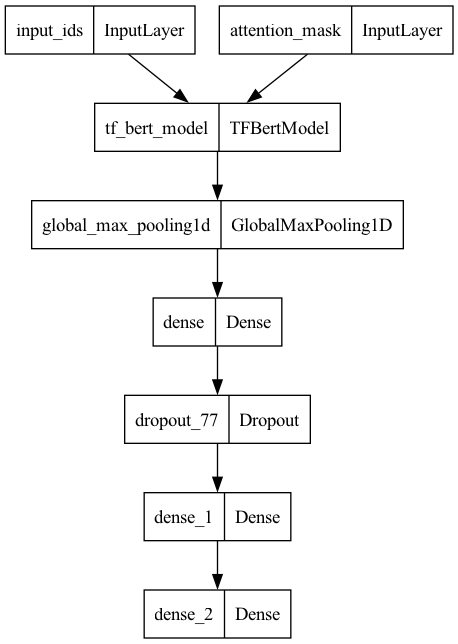

In [227]:
plot_model(model)

In [228]:
model.layers

## Model Fitting

In [229]:
model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(df_train['Sentiment']), ## convert y labels into one-hot encoding
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(df_test['Sentiment'])),
    epochs=1,
    batch_size=32
)

/Users/alvinchen/anaconda3/envs/tensorflowgpu/lib/python3.9/site-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


438/438 [==============================] - 298s 589ms/step - loss: 0.8426 - balanced_accuracy: 0.7034 - val_loss: 0.2887 - val_balanced_accuracy: 0.8975


## Evaluation

In [230]:
# Evaluation
from sklearn.metrics import classification_report

predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(df_test['Sentiment'], y_predicted))

188/188 [==============================] - 48s 221ms/step
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       813
           1       0.83      0.90      0.86       712
           2       0.95      0.90      0.92      2028
           3       0.77      0.85      0.81       492
           4       0.94      0.91      0.92      1739
           5       0.75      0.79      0.77       216

    accuracy                           0.90      6000
   macro avg       0.85      0.88      0.86      6000
weighted avg       0.90      0.90      0.90      6000



## Using Transformer-based Classifiers Directly

In our previous example, we built the classifier from the generic Bert model (`TFBertModel`). We can also use the `AutoModelForSequenceClassification` from Transformer to build a classifier, which features a BERT architecture.

:::{note}

In the Transformers library, which is commonly used for working with pre-trained transformer models like BERT, TFBertModel and AutoModelForSequenceClassification serve different purposes.

1. **TFBertModel:**
   - `TFBertModel` is a generic class for loading the BERT model architecture in TensorFlow. It provides the base BERT model that can be used for various tasks, but it doesn't have task-specific heads attached to it. This means it doesn't have a built-in mechanism for tasks like sequence classification. It is mainly used when you want to use BERT as a feature extractor or when you want to build a custom model on top of BERT for a specific task.

2. **AutoModelForSequenceClassification:**
   - `AutoModelForSequenceClassification` is a class specifically designed for sequence classification tasks using transformer models. It includes the BERT model architecture along with a classification head tailored for tasks like text classification. When you use this class, you don't need to add a separate classification head; it's already integrated into the model.


- Use `TFBertModel` when you need the base BERT model for tasks other than sequence classification or when you want to build a custom model architecture on top of BERT.

- Use `AutoModelForSequenceClassification` when your task is sequence classification (e.g., sentiment analysis, text categorization). It includes a classification head and is ready to be used for training or inference on classification tasks.

Choose the appropriate class based on your specific task requirements and whether you need a generic BERT model or a model tailored for sequence classification.

:::

In [9]:
# Fine-tune DistilBERT classifier
from transformers import TFAutoModelForSequenceClassification

bert_model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=6)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
y_train = np.array(df_train['Sentiment'])
y_train

array([2, 1, 4, ..., 0, 4, 5], dtype=int8)

:::{tip}

1. When using the generic BERT model, the `tokenizer()` should specify `return_tensor='tf'` for model building in tensforflow.
2. When using the TFAutoModelForSequenceClassification model, the `tokenizer()` should specify `return_tensor='np'` for model building in Transformer. Also, the output of `tokenizer()` needs to be converted into a `dict` (Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras)
)
:::

In [11]:
## Tokenizers
X_train = tokenizer(
    text=df_train['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='np',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)
X_train = dict(X_train)

In [13]:
from tensorflow.keras.optimizers import Adam


bert_model.compile(optimizer=Adam(3e-5), metrics=['accuracy'])  # No loss argument!
bert_model.fit(X_train, y_train)

2023-11-13 14:46:05.988958: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


438/438 [==============================] - 176s 359ms/step - loss: 0.5256 - accuracy: 0.8253


In [14]:
# Evaluation
from sklearn.metrics import classification_report


X_test= tokenizer(
    text=df_test['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='np',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = dict(X_test)

y_test = np.array(df_test['Sentiment'])

predicted = bert_model.predict(X_test)
y_predicted = np.argmax(predicted.logits, axis=1)
print(classification_report(y_test, y_predicted))

188/188 [==============================] - 40s 176ms/step
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       813
           1       0.86      0.92      0.89       712
           2       0.97      0.92      0.94      2028
           3       0.79      0.92      0.85       492
           4       0.96      0.95      0.95      1739
           5       0.98      0.68      0.80       216

    accuracy                           0.92      6000
   macro avg       0.91      0.89      0.89      6000
weighted avg       0.93      0.92      0.93      6000



## References

1. This tutorial is based on [this article](https://medium.com/mlearning-ai/fine-tuning-bert-using-tensorflow-21368d8414ba).
2. [3 ways to build neural networks in tf](
https://towardsdatascience.com/3-ways-to-build-neural-networks-in-tensorflow-with-the-keras-api-80e92d3b5b7e)
3. [Dropout layer]
(https://datasciocean.tech/deep-learning-core-concept/understand-dropout-in-deep-learning/)

## Fine-tune with Tensorflow Keras 

In [ ]:
# Load IMDB dataset
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")

# Preprocess data
from transformers import AutoTokenizer

PRETRAINED_MODEL = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)


In [ ]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Before you can use prepare_tf_dataset(), you will need to add the tokenizer outputs to your dataset as columns, as shown in the following code sample:

Remember that Hugging Face datasets are stored on disk by default, so this will not inflate your memory usage! Once the columns have been added, you can stream batches from the dataset and add padding to each batch, which greatly reduces the number of padding tokens compared to padding the entire dataset.

In [ ]:
def preprocess(examples):
    return tokenizer(examples["text"], max_length=200, padding=True, truncation=True)

tokenized_datasets = imdb_dataset.map(preprocess, batched=True)


In [ ]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

# Load and compile our model
model = TFAutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
tf_dataset_train = model.prepare_tf_dataset(tokenized_datasets["train"], batch_size=100, shuffle=True, tokenizer=tokenizer)



You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
tokenized_datasets['train']['text'][:10]


['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [ ]:
tokenized_datasets['train']['label'][:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
tokenized_datasets['train']['input_ids'][:10]

[[101,
  1045,
  12524,
  1045,
  2572,
  8025,
  1011,
  3756,
  2013,
  2026,
  2678,
  3573,
  2138,
  1997,
  2035,
  1996,
  6704,
  2008,
  5129,
  2009,
  2043,
  2009,
  2001,
  2034,
  2207,
  1999,
  3476,
  1012,
  1045,
  2036,
  2657,
  2008,
  2012,
  2034,
  2009,
  2001,
  8243,
  2011,
  1057,
  1012,
  1055,
  1012,
  8205,
  2065,
  2009,
  2412,
  2699,
  2000,
  4607,
  2023,
  2406,
  1010,
  3568,
  2108,
  1037,
  5470,
  1997,
  3152,
  2641,
  1000,
  6801,
  1000,
  1045,
  2428,
  2018,
  2000,
  2156,
  2023,
  2005,
  2870,
  1012,
  1026,
  7987,
  1013,
  1028,
  1026,
  7987,
  1013,
  1028,
  1996,
  5436,
  2003,
  8857,
  2105,
  1037,
  2402,
  4467,
  3689,
  3076,
  2315,
  14229,
  2040,
  4122,
  2000,
  4553,
  2673,
  2016,
  2064,
  2055,
  2166,
  1012,
  1999,
  3327,
  2016,
  4122,
  2000,
  3579,
  2014,
  3086,
  2015,
  2000,
  2437,
  2070,
  4066,
  1997,
  4516,
  2006,
  2054,
  1996,
  2779,
  25430,
  14728,
  2245,
  2055,
  305

In [ ]:

# Lower learning rates are often better for fine-tuning transformers
model.compile(optimizer=Adam(3e-5), metrics=["accuracy"])  # No loss argument!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


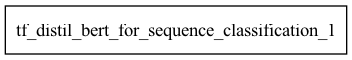

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes =True)

In [ ]:
history = model.fit(tf_dataset_train, epochs=2)

Epoch 1/2


2023-11-13 07:14:26.710497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


250/250 [==============================] - 305s 1s/step - loss: 0.3269 - accuracy: 0.8562
Epoch 2/2
250/250 [==============================] - 298s 1s/step - loss: 0.2021 - accuracy: 0.9192


In [ ]:
tf_dataset_test = model.prepare_tf_dataset(tokenized_datasets["test"], batch_size=100, shuffle=True, tokenizer=tokenizer)


In [212]:
model.evaluate(tf_dataset_test)

250/250 [==============================] - 95s 379ms/step - loss: 0.2553 - accuracy: 0.8991


[0.25525370240211487, 0.8991199731826782]

###  Confusion Matrix

In [ ]:
## tokenize test data "text"
X_test = tokenizer(tokenized_datasets['test']["text"], return_tensors="np", max_length=200, padding=True, truncation=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
X_test = dict(X_test)

## get test data "label"
y_test = np.array(tokenized_datasets['test']["label"])  # Label is already an array of 0 and 1


## model prediction
predictions = model.predict(X_test)

782/782 [==============================] - 111s 141ms/step


In [191]:
## Get model predicted labels
predicted_categories = np.argmax(predictions.logits, axis=1)
len(predicted_categories)


25000

In [198]:
print(y_test[:50])
print(predicted_categories[:50])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0]


In [199]:
import numpy as np

In [205]:
## Confusion Matrix Report
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

import numpy as np

cm = confusion_matrix(y_test, predicted_categories,  labels=[0,1])
print(classification_report(y_test, predicted_categories))



              precision    recall  f1-score   support

           0       0.92      0.87      0.90     12500
           1       0.88      0.93      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



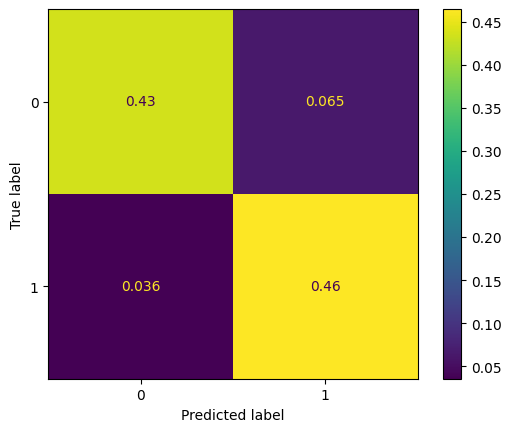

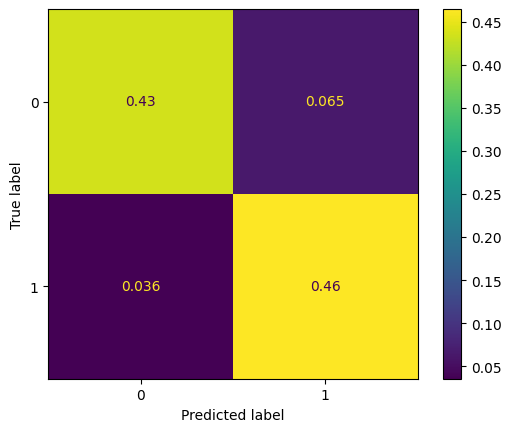

In [213]:
## Plot Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, predicted_categories, normalize='all')
disp.plot()
plt.show()

## Check GPU Availability

- [Install TensorFlow on Mac M1/M2 with GPU support](https://medium.com/mlearning-ai/install-tensorflow-on-mac-m1-m2-with-gpu-support-c404c6cfb580)
- [How to use GPU with Tensorflow and PyTorch libraries on MacBook pro M2(Apple Silicon)](https://www.linkedin.com/pulse/how-use-gpu-tensorflow-pytorch-libraries-macbook-pro-m2apple-kashyap)

In [110]:
## Check GPU support in tensorflow
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
#print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.1-arm64-arm-64bit
Tensor Flow Version: 2.14.0

Python 3.9.18 (main, Sep 11 2023, 08:25:10) 
[Clang 14.0.6 ]
Pandas 2.1.3
Scikit-Learn 1.3.2
SciPy 1.11.3
GPU is available


In [111]:
## Check GPU support in Pytorch

import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-14.1-arm64-arm-64bit
PyTorch Version: 2.2.0.dev20231112

Python 3.9.18 (main, Sep 11 2023, 08:25:10) 
[Clang 14.0.6 ]
Pandas 2.1.3
Scikit-Learn 1.3.2
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


/var/folders/70/qfdgs0k52qj24jtjcz7d0dkm0000gn/T/ipykernel_87205/704418618.py:10: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  has_mps = getattr(torch,'has_mps',False)
/var/folders/70/qfdgs0k52qj24jtjcz7d0dkm0000gn/T/ipykernel_87205/704418618.py:11: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch,'has_mps',False) \


## Fine-tune with PyTorch Trainer (Not working with Mac M2)

In [ ]:
# import os
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '0'
# import torch
# import torch
# device = torch.device('cpu')
# # model.to(device)
# device = torch.device('cpu')
# import torch
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     G.to(mps_device)
#     D.to(mps_device)

In [ ]:
# !pip install transformers datasets
# !pip install accelerate -U

In [ ]:
import torch

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

# # import torch
# device = torch.device('mps')

tensor([1.], device='mps:0')


In [ ]:
# Load IMDB dataset
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")

# Preprocess data
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [ ]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
len(tokenizer(imdb_dataset["train"]["text"][1], max_length=100)['input_ids'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


100

In [ ]:
# len(preprocess(imdb_dataset["train"][1])['input_ids'])

In [ ]:

def preprocess(examples):
    return tokenizer(examples["text"], max_length=200, padding=True, truncation=True)

tokenized_datasets = imdb_dataset.map(preprocess, batched=True)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
len(tokenized_datasets["test"]["input_ids"][1])

200

In [ ]:

# Prepare datasets
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))


In [ ]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [ ]:

# Fine-tune DistilBERT classifier
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# model = model.to('mps')



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", use_mps_device= True, no_cuda = True)
## Transformers still does not support m2 for GPU computing
## mps not working with m2 chip

# device = 'mps'
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

trainer.train()

# Evaluate
model.eval()
outputs = model(**eval_dataset[0])
predictions = outputs.logits.argmax(-1)